In [1]:
import pandas as pd
from datetime import datetime, timedelta, date
import numpy as np
from collections import Counter
from data_science_toolkit.data_visualization import get_fig_ax, visualize_class_distribution, top_n_tokens_plot_from_counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize 
from nltk.stem.snowball import SnowballStemmer
import nltk, re
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import LdaModel, CoherenceModel
from gensim import corpora, models, similarities 
from data_science_toolkit.association_rules import apriori_with_df
from data_science_toolkit.data_visualization import generate_histogram

In [2]:
output_col = 'above_monthly_avg'
file_name = 'trump_tweets_sp500.csv'
# file_name = 'elonmusk_twint_preprocessed.csv'

In [3]:
%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)

In [4]:
stop_words = set(stopwords.words('english')).union({'', 'would'})
# , '-', '&', '"', ':', '/'
stemmer = SnowballStemmer("english")

In [5]:
stock_tweet = pd.read_csv('./stocks/{}'.format(file_name))
stock_tweet['created_at']= pd.to_datetime(stock_tweet['created_at']) 

In [6]:
stock_tweet.head(2)

,text,retweet_count,retweet,num_videos,created_at,preprocessed_text,created_hour,dow,num_links,num_words,num_photos,above_monthly_avg,percent_caps,num_hashtags,num_mentions
0,"The Club For Growth,which asked me for $1,000,000 in an extortion attempt, just put up a Wisconsin ad with incorrect math.What a dumb group!",4791.0,False,0.0,2016-04-01 00:23:25,"the club for growth , which asked me for $ 1,000,000 in an extortion attempt , just put up a wisconsin ad with incorrect math.what a dumb group !",0,4,0,0.16,0,1,0.0,0,0
1,The Club For Growth said in their ad that 465 delegates (Cruz) plus 143 delegates (Kasich) is more than my 739 delegates. Try again!,4434.0,False,0.0,2016-04-01 00:29:49,the club for growth said in their ad that 465 delegates ( cruz ) plus 143 delegates ( kasich ) is more than my 739 delegates . try again !,0,4,0,0.17,0,1,0.0,0,0


In [8]:
prep_all_tweets = stock_tweet["preprocessed_text"].tolist()

# 1.0 Class Distribution

Exception in get_axis 'AxesSubplot' object has no attribute 'any'


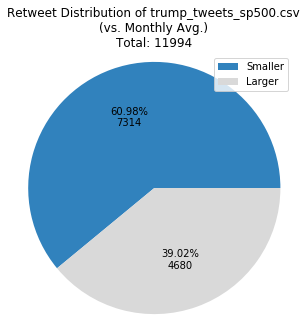

In [9]:
fig, ax = get_fig_ax(1, 1, 5, 5)
ax = visualize_class_distribution(stock_tweet[output_col], 
                                  given_title="Retweet Distribution of {}\n(vs. Monthly Avg.)".format(file_name), 
                                  given_label_titles={1: "Larger", 0:"Smaller"}, axes=ax, row_idx=0, col_idx=0)

# 2.0 Most Common Words

In [11]:
def filtered_word_array(tweet, words_to_ignore={}):
    return [x for x in tweet.split(' ') if x not in stop_words.union(words_to_ignore) and re.search('[a-zA-Z]', x)]

In [12]:
stock_tweet.iloc[3500]

text                 The era of strategic patience with the North Korea regime has failed. That patience is over. We are working closely with.... pic.twitter.com/nCZ51HnIdx
retweet_count        15124                                                                                                                                                  
retweet              False                                                                                                                                                  
num_videos           1                                                                                                                                                      
created_at           2017-06-30 16:55:44                                                                                                                                    
preprocessed_text    the era of strategic patience with the north korea regime has failed . that patience is over . we are working clos

Exception in get_axis 'AxesSubplot' object has no attribute 'any'


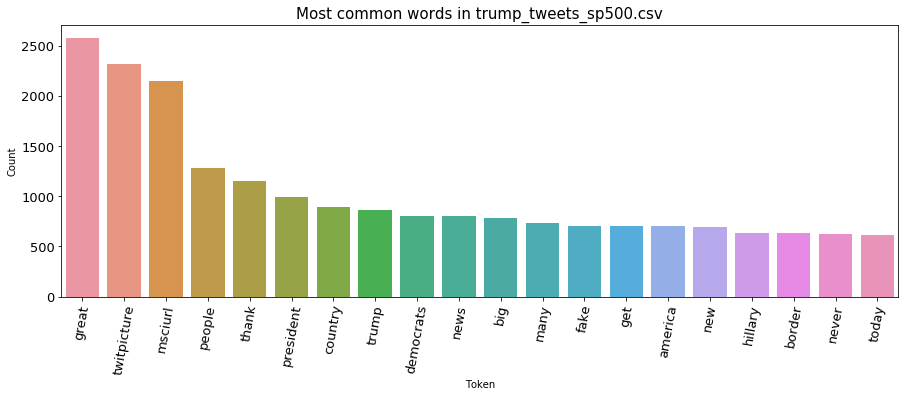

In [13]:
fig, ax = get_fig_ax(1, 1, 15, 5)
ax = top_n_tokens_plot_from_counter(Counter([x for x in filtered_word_array(' '.join(prep_all_tweets))]), 
                                    20, ax, 0, 0, "Most common words in {}".format(file_name))

## 2.1 Most Common Words (Larger vs Smaller than monthly average)

In [14]:
above_avg = stock_tweet[stock_tweet[output_col] == 1]
above_avg_since_election = stock_tweet[stock_tweet[output_col] == 1]
below_avg = stock_tweet[stock_tweet[output_col] == 0]
below_avg_stock_tweet = stock_tweet[stock_tweet[output_col] == 0]

In [15]:
def get_count_no_sw(df):
    return Counter(filtered_word_array(' '.join(df['preprocessed_text'].tolist())))

In [16]:
above_not_below = get_count_no_sw(above_avg) - get_count_no_sw(below_avg)
below_not_above = get_count_no_sw(below_avg) - get_count_no_sw(above_avg)

Exception in get_axis 'AxesSubplot' object has no attribute 'any'


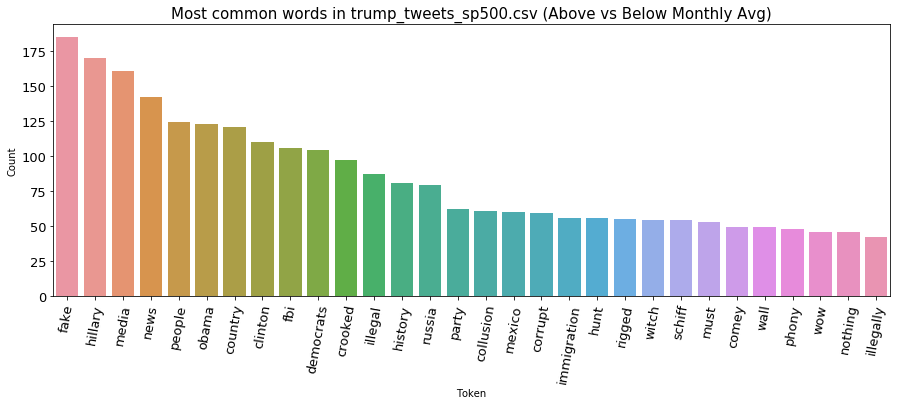

In [17]:
fig, ax = get_fig_ax(1, 1, 15, 5)
ax = top_n_tokens_plot_from_counter(above_not_below, 30, ax, 0, 0, 
                                    "Most common words in {} (Above vs Below Monthly Avg)".format(file_name))

Exception in get_axis 'AxesSubplot' object has no attribute 'any'


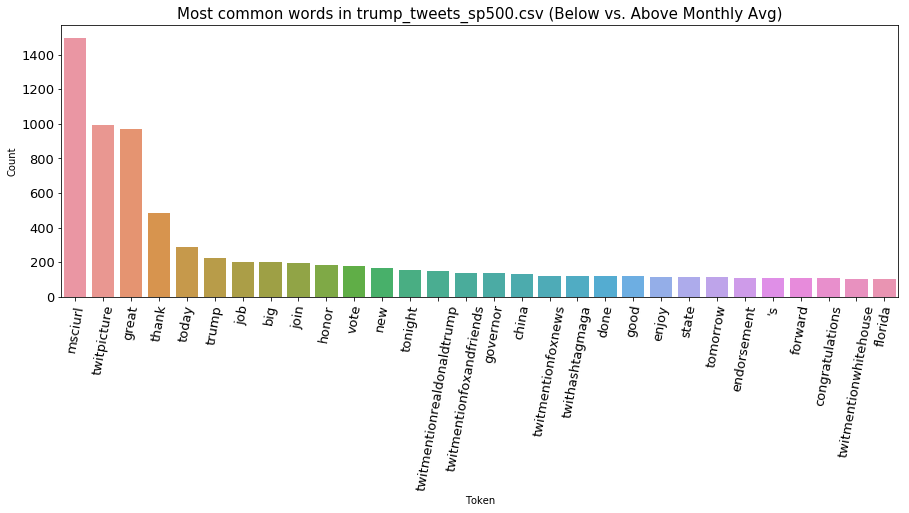

In [18]:
fig, ax = get_fig_ax(1, 1, 15, 5)
ax = top_n_tokens_plot_from_counter(below_not_above, 30, ax, 0, 0, 
                                    "Most common words in {} (Below vs. Above Monthly Avg)".format(file_name))

# 3.0 Apriori - Featuresets
- Due to the small number of tweets, etc, we need to use a relatively low support of 0.02 before starting to look for rules

In [19]:
def prep_fn(text):
    text = text.split(" ")
    final = []
    for word in text:
        if re.search('[a-zA-Z]', word) and word not in stop_words:
            final.append(word)
    return final

In [20]:
frequent_itemsets = apriori_with_df(prep_all_tweets, prep_fn, min_support=0.02, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.027681,('s)
1,0.023845,(also)
2,0.055278,(america)
3,0.034517,(american)
4,0.036602,(back)
5,0.034934,(bad)
6,0.020093,(better)
7,0.061114,(big)
8,0.043772,(border)
9,0.020010,(campaign)


## Using these frequent itemsets, we can come up with association rules:

In [21]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(news),(fake),0.062114,0.054944,0.046523,0.748993,13.631905,0.043110,3.765062
1,(fake),(news),0.054944,0.062114,0.046523,0.846737,13.631905,0.043110,6.119471
2,(states),(united),0.036018,0.036768,0.030682,0.851852,23.168052,0.029358,6.501813
3,(united),(states),0.036768,0.036018,0.030682,0.834467,23.168052,0.029358,5.823508
4,(witch),(hunt),0.024596,0.024596,0.024262,0.986441,40.106337,0.023657,71.936072
5,(hunt),(witch),0.024596,0.024596,0.024262,0.986441,40.106337,0.023657,71.936072
6,(crooked),(hillary),0.032850,0.051109,0.028097,0.855330,16.735444,0.026418,6.559002


## We can use these itemsets as inputs to our SVM

# WILL NEED TO MOVE THIS INTO THE CROSS VALIDATION PIPELINE!!!

In [22]:
above_avg_apr = apriori_with_df(stock_tweet[stock_tweet[output_col] == 1]['preprocessed_text'].tolist(), prep_fn).values.tolist()
above_avg_apr_dict = {x[1]: x[0] for x in above_avg_apr if len(x[1]) > 1}
above_avg_apr_set = set([x[1] for x in above_avg_apr])

In [23]:
below_avg_apr = apriori_with_df(stock_tweet[stock_tweet[output_col] == 0]['preprocessed_text'], prep_fn).values.tolist()
below_avg_apr_dict = {x[1]: x[0] for x in below_avg_apr if len(x[1]) > 1}
below_avg_apr_set = set([x[1] for x in below_avg_apr])

In [24]:
below_avg_apr_dict

{frozenset({'fake', 'news'}): 0.029258955427946404,
 frozenset({'great', 'twitpicture'}): 0.04552912223133716,
 frozenset({'great', 'today'}): 0.0220125786163522,
 frozenset({'great', 'msciurl'}): 0.04115395132622368,
 frozenset({'thank', 'twitpicture'}): 0.04826360404703309,
 frozenset({'msciurl', 'twitpicture'}): 0.0701394585726005,
 frozenset({'states', 'united'}): 0.02378999179655455,
 frozenset({'today', 'twitpicture'}): 0.02693464588460487,
 frozenset({'great', 'make'}): 0.021192234071643425,
 frozenset({'great', 'people'}): 0.02392671588733935,
 frozenset({'america', 'twitpicture'}): 0.020371889526934646,
 frozenset({'america', 'great'}): 0.025977577249111292,
 frozenset({'join', 'msciurl'}): 0.025977577249111292,
 frozenset({'honor', 'twitpicture'}): 0.020782061799289035,
 frozenset({'msciurl', 'thank'}): 0.04552912223133716,
 frozenset({'great', 'job'}): 0.02543068088597211,
 frozenset({'great', 'thank'}): 0.030352748154224774}

In [25]:
above_avg_apr_diff = Counter(above_avg_apr_dict) - Counter(below_avg_apr_dict)

In [26]:
below_avg_apr_diff = Counter(below_avg_apr_dict) - Counter(above_avg_apr_dict)

In [27]:
below_avg_apr_diff.items()

dict_items([(frozenset({'thank', 'twitpicture'}), 0.01621232199575104), (frozenset({'great', 'twitpicture'}), 0.02330690000911494), (frozenset({'great', 'today'}), 0.0220125786163522), (frozenset({'great', 'msciurl'}), 0.04115395132622368), (frozenset({'msciurl', 'twitpicture'}), 0.0701394585726005), (frozenset({'today', 'twitpicture'}), 0.02693464588460487), (frozenset({'msciurl', 'join'}), 0.025977577249111292), (frozenset({'america', 'twitpicture'}), 0.020371889526934646), (frozenset({'thank', 'msciurl'}), 0.04552912223133716), (frozenset({'honor', 'twitpicture'}), 0.020782061799289035), (frozenset({'great', 'job'}), 0.02543068088597211), (frozenset({'great', 'thank'}), 0.030352748154224774)])

In [28]:
above_avg_apr_feats = sorted([x for x in above_avg_apr_diff.most_common(4) if x[1] > 0.04], key=lambda x: x[1], reverse=True)
below_avg_apr_feats = sorted([x for x in below_avg_apr_diff.most_common(4) if x[1] > 0.04], key=lambda x: x[1], reverse=True)

In [29]:
above_avg_apr_feats

[(frozenset({'crooked', 'hillary'}), 0.04487179487179487),
 (frozenset({'fake', 'news'}), 0.0442453180763271)]

In [30]:
# feat = above_avg_apr_feats[0]

In [31]:
def contains_feature(tweets, feat):
    contains_feat_list = []
    for tweet in tweets:
        curr_set = [1 if word in set(tweet) else 0 for word in feat]
        contains_feat_list.append(min(curr_set))
    return contains_feat_list

In [32]:
tweets = list(map(lambda x: x.split(" "), prep_all_tweets))

In [33]:
for feat in above_avg_apr_feats:
    col_name = "above_avg_apr_{}".format('_'.join(feat[0]))
    stock_tweet[col_name] = contains_feature(tweets, feat[0])
    stock_tweet[col_name] = stock_tweet[col_name].astype('category')

In [34]:
for feat in below_avg_apr_feats:
    col_name = "below_avg_apr_{}".format('_'.join(feat[0]))
    stock_tweet[col_name] = contains_feature(tweets, feat[0])
    stock_tweet[col_name] = stock_tweet[col_name].astype('category')

In [35]:
# since_election.columns

### 3.something Kmeans
- https://medium.com/wisio/a-gentle-introduction-to-doc2vec-db3e8c0cce5e

# K-Means Clustering for Common Topics

Summarize this but don't need to say much else

Ran out of memory trying to do this for all Trump tweets - I'm only going to do it for tweets since the election.  
Elbow method: https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f

In [36]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [37]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(list(map(lambda x: [stemmer.stem(yeet) for yeet in x.split(" ") if re.search('[a-zA-Z]', yeet) and yeet not in stop_words.union({'msciurl', 'twitpicture', "'s"})], prep_all_tweets)))]
model = Doc2Vec(documents, vector_size=30, window=2, min_count=1, workers=4)

In [38]:
model.train(documents, total_examples=model.corpus_count, epochs=10, start_alpha=0.002, end_alpha=-0.016)

In [39]:
model.docvecs.doctag_syn0

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  """Entry point for launching an IPython kernel.


array([[ 0.0636289 , -0.37058914, -0.07570374, ...,  0.13836598,
         0.12856182, -0.04244406],
       [ 0.04225202, -0.23158881, -0.04435058, ...,  0.08609419,
         0.08123738,  0.00472319],
       [ 0.02075376, -0.16917807, -0.02034856, ...,  0.07984713,
         0.06977612, -0.01034171],
       ...,
       [ 0.01814339, -0.10941339, -0.03150152, ...,  0.02416584,
         0.03921717, -0.01588716],
       [-0.00193785, -0.10833081, -0.02132832, ...,  0.02514605,
         0.04308847,  0.00535769],
       [-0.00170237, -0.0403199 , -0.00079443, ...,  0.03331731,
         0.01619621,  0.00622249]], dtype=float32)

In [40]:
from sklearn.externals import joblib
from sklearn.cluster import KMeans
def kmeans(num_clusters, term_matrix):
    km = KMeans(n_clusters=num_clusters, max_iter=1000000, n_jobs=6, n_init=30)
    labels = km.fit_predict(term_matrix)
    return km, labels, km.inertia_

/usr/local/lib/python3.5/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [41]:
def tokenize_only(tweet):
    return [stemmer.stem(x) for x in tweet.split(" ") if re.search('[a-zA-Z]', x) and x not in stop_words.union({'msciurl', 'twitpicture', "'s"})]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  after removing the cwd from sys.path.


Iter: 2 , Num Iter:  10 Inertia:  863.296003594314
Iter: 4 , Num Iter:  11 Inertia:  295.2701163175038
Iter: 8 , Num Iter:  21 Inertia:  117.03289177285872
Iter: 10 , Num Iter:  45 Inertia:  92.07378926037057
Iter: 20 , Num Iter:  22 Inertia:  53.25522906112761
Iter: 30 , Num Iter:  60 Inertia:  45.90178518713665
Iter: 40 , Num Iter:  31 Inertia:  43.36518998012289
Iter: 50 , Num Iter:  62 Inertia:  41.95566885606441
Iter: 60 , Num Iter:  59 Inertia:  40.86777523392397
Iter: 70 , Num Iter:  34 Inertia:  39.985028793680044
Iter: 80 , Num Iter:  43 Inertia:  39.274847311531104
Iter: 90 , Num Iter:  63 Inertia:  38.68663642341765


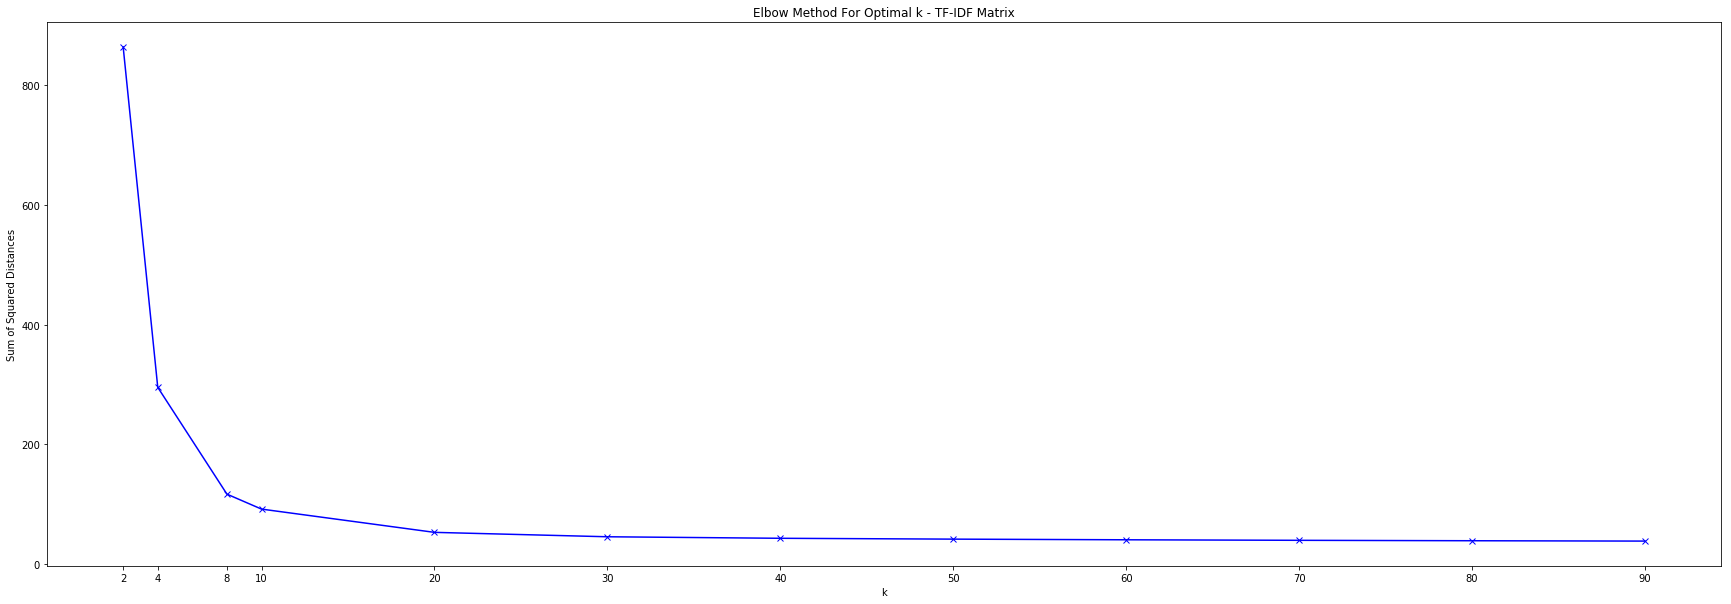

In [42]:
from data_science_toolkit.clustering import find_optimal_num_clusters
# tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, use_idf=True, tokenizer=tokenize_only, ngram_range=(1,5))
# tfidf_matrix = tfidf_vectorizer.fit_transform(stock_tweet["preprocessed_text"].tolist()) #fit the vectorizer to synopses
find_optimal_num_clusters(model.docvecs.doctag_syn0, "TF-IDF Matrix", kmeans)

In [43]:
num_clusters = 8
km, labels, km.inertia_ = kmeans(num_clusters, model.docvecs.doctag_syn0)
# After finding using elbow method...
# joblib.dump(km,  'doc_cluster.pkl')
# km = joblib.load('doc_cluster.pkl')
# clusters = km.labels_.tolist()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  


In [44]:
labels.shape

(11994,)

In [48]:
from sklearn.metrics import pairwise_distances_argmin_min
doc_labels = km.labels_.tolist()
centers = np.array(km.cluster_centers_)
doc_vectors = model.docvecs.doctag_syn0.tolist()
center_distances = [np.linalg.norm(vec-centers[label]) for vec, label in zip(doc_vectors, doc_labels)]
len(center_distances)
#     center_distance = 
# center_distances = list(map(lambda x: np.linalg.norm(centers[]-)))
df = pd.DataFrame({"preprocessed_text": prep_all_tweets, 
                   "cluster": doc_labels, 
                   "vector": doc_vectors, 
                   "center_dist": center_distances})

for i in range(num_clusters):
    tmp = df[df["cluster"] == i]
    tmp = tmp.sort_values(by="center_dist", ascending=True)
    print("Most Common Words (Counter) in Cluster {}".format(i))
    print(Counter(filtered_word_array(' '.join(tmp['preprocessed_text'].tolist()))).most_common(5))
    print("Highest value TF-IDF Words in Cluster {}".format(i))
    vectorizer = TfidfVectorizer(min_df=5, max_df=0.8, tokenizer=tokenize_only)
    X = vectorizer.fit_transform(tmp['preprocessed_text'].tolist())
    indices = np.argsort(vectorizer.idf_)[::-1]
    features = vectorizer.get_feature_names()
    top_n = 10
    top_features = [features[i] for i in indices[:top_n]]
    print(top_features)
    print("Tweets in Cluster {} with Lowest Centroid Distance:".format(i))
    print(tmp.head(10)[["center_dist", 'preprocessed_text']])
    print()
    print()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  after removing the cwd from sys.path.


Most Common Words (Counter) in Cluster 0
[('twitpicture', 720), ('msciurl', 598), ('great', 388), ('thank', 352), ('america', 187)]
Highest value TF-IDF Words in Cluster 0
['save', 'twithashtagweeklyaddressflagunitedst', 'farmer', 'tremend', 'p.m.', 'perhap', 'berni', 'progress', 'eric', 'endors']
Tweets in Cluster 0 with Lowest Centroid Distance:
       center_dist  \
570    0.039139      
1937   0.039666      
11361  0.039946      
3570   0.040116      
9271   0.040811      
10820  0.041287      
7046   0.042085      
9891   0.042424      
7912   0.042475      
10275  0.042714      

                                                                 preprocessed_text  
570    today we , together , won the republican nomination for president ! msciurl  
1937   is this really america ? terrible ! twitpicture                              
11361  twitpicture                                                                  
3570   big wins against isis !                                     

## 3.3 LDA for Topic Clustering - SKIPPING FOR NOW, SINCE IT'S NOT TECHNICALLY PART OF THE REPORT

This section focuses on using Latent Dirichlet Allocation (LDA). LDA is a probabilistic topic model that assumes documents are a mixture of topics and that each word in the document is attributable to the document's topics. 
https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

HAD TO ADD THE WORD "GREAT" TO THE STOPWORD LIST BECAUSE IT WAS IN LITERALLY EVERY CLUSTER...

In [ ]:
# Remove proper nouns (in this case get rid of all mentions)
# TRUMP ==============================================================================================================
stock_tweet['preprocessed_no_mentions'] = stock_tweet['preprocessed_text'].apply(lambda tweet: ' '.join([w for w in tweet.split(' ') 
                                                                                                               if w not in stop_words.union({'msciurl', 'twitpicture', 'great'}) 
                                                                                                               and re.search('[a-zA-Z]', w)]))

# ELON MUSK ===========================================================================================================
# Remove proper nouns (in this case get rid of all mentions)
# stock_tweet['preprocessed_no_mentions'] = stock_tweet['preprocessed_text'].apply(lambda tweet: ' '.join([w for w in tweet.split(' ') 
#                                                                                                                if w not in stop_words.union({'msciurl', 'twitpicture', "'s'"}) 
#                                                                                                                and re.search('[a-zA-Z]', w)]))

In [ ]:
texts = [[ting for ting in x.split(" ") if ting != ''] for x in stock_tweet['preprocessed_no_mentions'].tolist()]
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.3)
# 0.21

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
coherence_scores = []
for i in range(2, 50, 2):
    lda = models.LdaMulticore(corpus, num_topics=i, 
                                id2word=dictionary, iterations=500)
    coherence_model_lda = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_scores.append(coherence_lda)

In [ ]:
# coherence_scores

In [ ]:
plt.plot([x for x in range(2, 50, 2)], coherence_scores)
plt.ylabel("Coherence Scores")
plt.xlabel("Num Topics")

In [ ]:
lda_num_topics = 12

In [ ]:
lda = models.LdaMulticore(corpus, num_topics=lda_num_topics, iterations=500,
                                id2word=dictionary)

In [ ]:
lda.show_topics(num_topics=lda_num_topics)

- The area of circle represents the importance of each topic over the entire corpus
- The distance between the center of circles indicate the similarity between topics.
- Indices = sorted order by area
- Blue = overall term frequency
- Red = term freq within selected topic
- Lambda: trying to strike a balance between choosing general vs specific words (lambda=0 means super specific - exclusively popular for this topic)
- If some topics contain general words/feelings/sentiments

In [ ]:
# https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
# df_dominant_topic.head(10)
df_dominant_topic['preprocessed_text'] = prep_all_tweets

In [ ]:
# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda.show_topics(num_topics=lda_num_topics, formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

# print(lda.show_topics(num_topics=lda_num_topics, formatted=False))

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(' '.join)
df_top3words.reset_index(level=0,inplace=True)
df_top3words

In [ ]:
df = None
sample_size=5
for i in range(lda_num_topics):
    curr_cluster = df_dominant_topic[df_dominant_topic['Dominant_Topic'] == i].sort_values(by='Topic_Perc_Contrib', ascending=False)
    if df is None:
        df = curr_cluster.head(sample_size)#.sample(n=min(sample_size, len(curr_cluster.index)-1))
    else:
        df = df.append(curr_cluster.head(sample_size))#curr_cluster.sample(n=min(sample_size, len(curr_cluster.index)-1)))
    df = df.append(pd.Series(), ignore_index=True)
df[["preprocessed_text", "Dominant_Topic", 'Topic_Perc_Contrib']]

# SAVE DATA (COMMENTED OUT)

In [ ]:
# lda.save('44_clusters_removed_great_lda.model')
# df.to_csv('lda_44_clusters_removed_great.csv', index=False)

# LDA VISUALIZATION

In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary=lda.id2word)
vis

# 4.0 Distributions

## 4.1.1 Time of Day (Up vs Down)

In [ ]:
fig, ax = get_fig_ax(1, 1, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["created_hour"], ax, 0, 0, "Hour of Day", "Tweets (%)", 
                        "Number of Tweets vs. Time of Day (Above Monthly Average)", True, show_mean=False, show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 1, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["created_hour"], ax, 0, 0, "Hour of Day", "Tweets (%)", 
                        "Number of Tweets vs. Time of Day (Below Monthly Average)", True, show_mean=False, show_sd=False, show_best_fit=False)

## 4.2.1 Day of Week (Up vs Down)

In [ ]:
fig, ax = get_fig_ax(1, 1, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["dow"], ax, 0, 0, "Day of Week", "Tweets (%)", 
                        "Number of Tweets vs. Day of Week (Above Monthly Average)", False, show_mean=False, show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 1, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["dow"], ax, 0, 0, "Day of Week", "Tweets (%)", 
                        "Number of Tweets vs. Day of Week (Below Monthly Average)", False, show_mean=False, show_sd=False, show_best_fit=False)

## 4.3 Num Retweets over Time

In [ ]:
from data_science_toolkit.file_ops import read_pkl
dt_avg = read_pkl("dt_avg_{}.pkl".format(file_name))

In [ ]:
avg_retweets, dates = [], []
for year in dt_avg:
    for month in dt_avg[year]:
        avg_retweets.append(dt_avg[year][month])
        dates.append(datetime(year, month, 1))
dates, avg_retweets = list(zip(*sorted(list(zip(dates, avg_retweets)), key=lambda x: x[0])))

# Average Number of Retweets per Month
- The average number of retweets Trump gets per month varies significantly, and also jumped during the middle of the year (around when he got elected)
- This makes comparing to a monthly average more appropriate

In [ ]:
fig = plt.figure(figsize=(30, 10))
plt.plot(dates, avg_retweets)
fig.suptitle('Monthly Retweet Average')
plt.xlabel('Year/Month')
plt.ylabel('Num Retweets')
plt.xticks(dates, [x.strftime('%m-%d-%Y') for x in dates], rotation=90)
plt.grid(True)
plt.show()

## 5.1 Tweet Anatomy

In [ ]:
fig, ax = get_fig_ax(1, 1, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["num_words"], ax, 0, 0, 
                        "Number of Words in Tweet", "Tweets (%)", "Number of Tweets vs. Number of Words in Tweet (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 1, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["num_words"], ax, 0, 0, 
                        "Number of Words in Tweet", "Tweets (%)", "Number of Tweets vs. Number of Words in Tweet (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)

In [ ]:
# stock_tweet[since_election.num_words > 55]

In [ ]:
set(stock_tweet[stock_tweet[output_col] == 0]['num_links'].tolist())

In [ ]:
fig, ax = get_fig_ax(1, 1, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["num_links"], ax, 0, 0, 
                        "Number of Links in Tweet", "Tweets (%)", "Number of Tweets vs. Number of Links in Tweet (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 1, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["num_links"], ax, 0, 0, 
                        "Number of Links in Tweet", "Tweets (%)", "Number of Tweets vs. Number of Links in Tweet (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)

In [ ]:
fig, ax = get_fig_ax(1, 1, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["percent_caps"], ax, 0, 0, 
                        "Percent Caps", "Tweets (%)", "Number of Tweets vs. Percent Caps (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 1, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["percent_caps"], ax, 0, 0, 
                        "Percent Caps", "Tweets (%)", "Number of Tweets vs. Percent Caps (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)

In [ ]:
fig, ax = get_fig_ax(1, 1, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["num_hashtags"], ax, 0, 0, 
                        "Num Hashtags", "Tweets (%)", "Number of Tweets vs. Num Hashtags (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 1, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["num_hashtags"], ax, 0, 0, 
                        "Num Hashtags", "Tweets (%)", "Number of Tweets vs. Num Hashtags (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)

In [ ]:
fig, ax = get_fig_ax(1, 1, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["num_mentions"], ax, 0, 0, 
                        "Num Mentions", "Tweets (%)", "Number of Tweets vs. Num Mentions (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 1, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["num_mentions"], ax, 0, 0, 
                        "Num Mentions", "Tweets (%)", "Number of Tweets vs. Num Mentions (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)

In [ ]:
fig, ax = get_fig_ax(1, 1, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["num_videos"], ax, 0, 0, 
                        "Num Videos", "Tweets (%)", "Number of Tweets vs. Num Videos (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 1, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["num_videos"], ax, 0, 0, 
                        "Num Videos", "Tweets (%)", "Number of Tweets vs. Num Videos (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)

In [ ]:
fig, ax = get_fig_ax(1, 1, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 1]["num_photos"], ax, 0, 0, 
                        "Num Photos", "Tweets (%)", "Number of Tweets vs. Num Photos (Above Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)
fig, ax = get_fig_ax(1, 1, 20, 8)
ax = generate_histogram(stock_tweet[stock_tweet[output_col] == 0]["num_photos"], ax, 0, 0, 
                        "Num Photos", "Tweets (%)", "Number of Tweets vs. Num Photos (Below Monthly Average)", True, 
                        show_sd=False, show_best_fit=False)

In [ ]:
# stock_tweet.head(10)

In [ ]:
# since_election.head(10)

## This is what we will be using for models...

In [ ]:
stock_tweet.to_csv('./since_election_with_cluster_{}'.format(file_name), index=False)